In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
# List all the child layers of the pre-trained model using list() and the children() method 
# Then, use Python's slicing syntax to extract the last three layers
# This can help us understand the structure of the model, especially when we intend to fine-tune the model 
# or use specific layers for feature extraction.

list(pretrained_net.children())[-3:]  # View the structure of the last three layers


d:\ANACONDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ANACONDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
# Create an instance of a fully convolutional network 'net'.
# Use a pre-trained ResNet18 model to create a new neural network.
# The code "*list(pretrained_net.children())[:-2]" takes all the child layers of the ResNet18 model 
# except the last two layers and assigns them as the layers of the new network.
# Therefore, the new network is essentially the version of ResNet18 without its last two layers.
# This approach is commonly used in transfer learning, where a model pre-trained on a large dataset 
# is utilized for feature extraction to assist with a new task.

net = nn.Sequential(*list(pretrained_net.children())[:-2])  # Remove the last two layers of ResNet18

# Create a tensor of shape (1, 3, 320, 480), which represents an image with a shape of (320, 480) and three color channels.
# Here, 3 represents the number of color channels (red, green, blue), and 320 and 480 denote the height and width of the image.
# The random tensor's elements are randomly generated between [0, 1) and can be seen as pixel values of a random image.
X = torch.rand(size=(1, 3, 320, 480))  # Convolutional layers are independent of input size; fully connected layers depend on input size.

# Input the randomly generated image tensor into the network by calling net(X) to perform forward propagation.
# Print the shape of the output tensor, which is usually used to verify if the network structure is correct.
# For fully convolutional networks, the width and height of the output are usually smaller than the input due to convolution and pooling operations.
# In this example, the width and height of the output should be 1/32 of the input due to the ResNet18 structure.
net(X).shape  # Shrunk by a factor of 32


torch.Size([1, 512, 10, 15])

In [4]:
# Use a 1x1 convolutional layer to transform the number of output channels to the number of classes in the Pascal VOC2012 dataset (21 classes).
# Increase the height and width of the feature map by a factor of 32.
# Define the number of classes in the target dataset. Here, 21 represents the 21 classes in the Pascal VOC2012 dataset, including 20 object classes and 1 background class.
num_classes = 21

# Add a new convolutional layer at the end of the network. This is a 1x1 convolutional layer with an input channel of 512 (determined by the earlier ResNet18 model).
# The output channel corresponds to the number of classes we defined, which is 21.
# 1x1 convolutional layers are often used to alter the number of channels, projecting the previous layer's feature maps into a new space with the output channel number.
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))

# Since the image is enlarged by a factor of 32, the stride is set to 32.
# Padding is determined by the kernel to maintain the minimum height and width, 16 * 2 = 32, padding is applied equally on both sides of the image.
# With a kernel size of 64, it effectively takes half the size of the image (32) and accounts for the padding of 32, essentially covering the entire image.
# Additionally, add a transposed convolutional layer, also known as a deconvolution layer, commonly used to upsample small feature maps to the original size.
# Both the input and output channel numbers are set to num_classes, indicating that we aim to maintain the same number of channels during upsampling.
# The kernel_size is 64, stride is 32, meaning this layer will increase the width and height of the feature map by a factor of 32.
# Padding is 16, which adds extra regions at the edges of the feature map to ensure the output size is exactly 32 times the input size.
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))


In [5]:
# Implementation of the bilinear interpolation kernel
# Define a function to initialize the bilinear interpolation kernel
# This function takes three parameters: input channels, output channels, and kernel size
def bilinear_kernel(in_channels, out_channels, kernel_size):
    # Calculate the position of the center point of the bilinear interpolation kernel
    # Calculate half the size of the bilinear interpolation kernel. As we want the center point to be at the center of the kernel, we need to calculate half of the kernel size.
    # Use the // operator for integer division to ensure the result is an integer
    factor = (kernel_size + 1) // 2
    # Determine the position of the center point based on whether the kernel size is odd or even
    # If the kernel size is odd, the center point is at half the size minus 1, because Python indexing starts from 0
    # For example, if the kernel size is 3, the center point should be at position 1: (3+1)//2 - 1 = 1
    if kernel_size % 2 == 1:
        center = factor - 1
    # If the kernel size is even, the center point is at half the size minus 0.5
    # This is because even-sized kernels don't have a clear center point, so we take the average position between the two middle elements as the center point
    # For example, if the kernel size is 4, the center point should be at position 1.5: (4+1)//2 - 0.5 = 1.5
    else:
        center = factor - 0.5
    # Create a matrix where the elements' values are equal to their distance from the center point
    og = (torch.arange(kernel_size).reshape(-1,1),
         torch.arange(kernel_size).reshape(1,-1))
    # Calculate the bilinear interpolation kernel, where values decay linearly from the center point outwards
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    # Initialize a weight matrix with zeros, size: (input channels, output channels, kernel size, kernel size)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    # Assign the values of the bilinear interpolation kernel to the corresponding positions in the weight matrix
    weight[range(in_channels), range(out_channels), :, :] = filt
    # Return the initialized weight matrix, which can be directly used to initialize the weights of the transposed convolutional layer
    return weight


input image shape: torch.Size([768, 1024, 3])
output image shape: torch.Size([1536, 2048, 3])


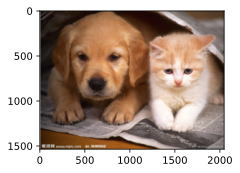

In [6]:
# Experimenting with bilinear interpolation for upsampling
# Create a transposed convolutional layer with input and output channels set to 3,
# as we're working with an RGB image where each color channel needs processing.
# The kernel size is 4, and the stride is 2, implying that this layer will upscale the input's width and height by a factor of 2.
# Set bias to False because we don't need a bias term.
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)

# Initialize the weights of the transposed convolutional layer using the bilinear interpolation kernel.
# Here, we utilize the copy_ method, which modifies the values of the original tensor in place.
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))  # Initialize weights with a bilinear kernel

# Convert an image in JPEG format to a tensor using torchvision.transforms.ToTensor()
img = torchvision.transforms.ToTensor()(d2l.Image.open('03_catdog.jpg'))

# Add a batch dimension to the image tensor
X = img.unsqueeze(0)

# Input the image tensor into the transposed convolutional layer to obtain the upsampled result
Y = conv_trans(X)

# Convert the output result to a displayable format: (height, width, color channel),
# and detach it from the computation graph to convert it to a NumPy array
out_img = Y[0].permute(1, 2, 0).detach()

# Set the display size of the image
d2l.set_figsize()

# Print the shape of the input image
print('input image shape:', img.permute(1, 2, 0).shape)

# Display the input image
d2l.plt.imshow(img.permute(1, 2, 0))

# Print the shape of the output image and display it
# Notice that the output image's width and height are both twice that of the input, as we set the stride to 2
print('output image shape:', out_img.shape)  # Output is enlarged by a factor of 2
# Display the output image
d2l.plt.imshow(out_img)


In [7]:
# Initializing the transposed convolutional layer with bilinear interpolation for upsampling
# For the 1x1 convolutional layer, we're using Xavier initialization for the parameters
# Initializing the weights of the transposed convolutional layer using a bilinear interpolation kernel
# num_classes represents the number of classes in the target dataset, and here, the size of the bilinear interpolation kernel is set to 64
W = bilinear_kernel(num_classes, num_classes, 64)

# Copy the initialized weight W to the transposed convolutional layer's weights
# Use the copy_ method for an in-place operation, directly modifying the values of the original tensor
net.transpose_conv.weight.data.copy_(W)


tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [8]:
# Reading the dataset
# Setting batch size and image cropping size
# Batch size represents the number of samples processed simultaneously in one training iteration, impacting the training speed and effectiveness of the model
# Crop size refers to the image size fed into the model, which needs to match the input layer size of the model. Different models may require different input sizes
batch_size, crop_size = 32, (320, 480)

# Using the d2l.load_data_voc function to read the VOC2012 dataset
# This function will return training and testing data iterators. Data iterators produce data in batches, facilitating model training
# During data loading, images will be cropped to the specified size and undergo standard data augmentation operations like random cropping, flipping, etc.
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)


read 1114 examples
read 1078 examples


In [10]:
# Training
# Defining the loss function; here, we're using cross-entropy loss
# inputs represent the network's predicted output, while targets are the ground truth labels
# Cross-entropy loss evaluates the predictions for each pixel and then computes the average loss
# Using the reduction='none' option prevents automatic averaging or summation of the loss, so we need to compute the mean manually
def loss(inputs, targets):
    # Previously, predicting a label resulted in a single value; now, predicting all labels for all pixels results in a matrix of losses
    # .mean(1).mean(1) takes the mean across the height and width dimensions, providing a single loss value for each image
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

# Setting training parameters: number of epochs (num_epochs), learning rate (lr), weight decay (wd), and devices
# Here, we're using all available GPUs for training. If no GPUs are available, it will use the CPU
# num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()

# Initializing the optimizer, using stochastic gradient descent (SGD) optimizer
# The optimizer updates the model's parameters to minimize the loss function
# The lr parameter is the learning rate, and weight decay (wd) helps prevent overfitting
# trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# Calling the d2l.train_ch13 function for training
# This function iterates through the training data in each training epoch and evaluates the model's performance on the test data
# The loss function and optimizer guide the model's training process
# d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


loss 0.149, train acc 0.946, test acc 0.867
4.6 examples/sec on [device(type='cpu')]


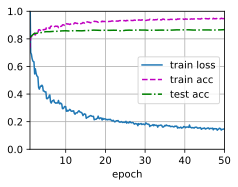

In [11]:
# Setting training parameters
num_epochs, lr, wd = 50, 0.001, 1e-3

# Trying to obtain all available GPUs; if none are available, use CPU
devices = d2l.try_all_gpus()
if not devices:  # If no GPUs are available, set the devices list to CPU
    devices = [torch.device('cpu')]

# Initializing the optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# Calling the training function
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


In [12]:
# Prediction
# Defining the prediction function; the input parameter img is the image to be predicted
def predict(img):
    # First, normalize the image and add a batch dimension to match the model's input requirements
    # The normalize_image function normalizes each pixel in the image to have values between 0 and 1
    # unsqueeze(0) adds a new dimension in the first dimension (batch dimension)
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # Next, input the preprocessed image into the model for prediction
    # Move the image data to the device (such as GPU)
    # Use argmax(dim=1) to find the class with the highest probability in the prediction results and return the index of this class
    pred = net(X.to(devices[0])).argmax(dim=1)  # Taking argmax across the channel dimension, giving the predicted label for each pixel
    # Finally, reshape the prediction results to match the shape of the original image
    # Reshape the shape of the prediction results to (height, width), so that each pixel has a corresponding class label
    return pred.reshape(pred.shape[1], pred.shape[2])  # A matrix equivalent to the height and width of the image


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

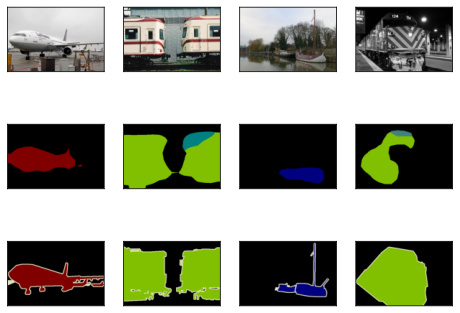

In [13]:
# Visualizing predicted classes
# Defining a function to convert predicted classes into an image
def label2image(pred):
    # Using VOC_COLORMAP to convert classes to RGB colors
    # VOC_COLORMAP is a list containing 21 different RGB colors, each corresponding to an object class
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])  # Converting class RGB values into a tensor
    # Converting the prediction results to long type to match the color map index
    X = pred.long()  # Converting the predicted values into indices
    # Finding the corresponding colors based on the class indices
    return colormap[X, :]  # Drawing the predicted RGB values

# Downloading and extracting the VOC2012 dataset
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
# Reading the test images and labels from the VOC2012 dataset
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
# Setting n to 4, indicating processing of 4 images. imgs: an empty list to store images.
n, imgs = 4, []
# Looping over predictions for 4 test samples and converting the prediction results to images
for i in range(n):
    # Setting the cropping area
    crop_rect = (0, 0, 320, 480)
    # Cropping the image
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    # Predicting on the cropped image and converting the prediction results into images
    pred = label2image(predict(X))  # Converting predictions into images
    # Adding the original image, predicted image, and label image to the imgs list
    imgs += [X.permute(1, 2, 0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1, 2, 0)]
# Displaying the original image, predicted image, and label image
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)  # Second row is predicted, third row is ground truth


In [14]:
# Save the model
torch.save(net.state_dict(), 'model50.pth')

input image shape: torch.Size([768, 1024, 3])
output image shape: torch.Size([1536, 2048, 3])
read 1114 examples
read 1078 examples


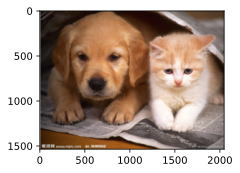

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

pretrained_net = torchvision.models.resnet18(pretrained=True)
# List all the child layers of the pre-trained model using list() and the children() method 
# Then, use Python's slicing syntax to extract the last three layers
# This can help us understand the structure of the model, especially when we intend to fine-tune the model 
# or use specific layers for feature extraction.

list(pretrained_net.children())[-3:]  # View the structure of the last three layers
# Create an instance of a fully convolutional network 'net'.
# Use a pre-trained ResNet18 model to create a new neural network.
# The code "*list(pretrained_net.children())[:-2]" takes all the child layers of the ResNet18 model 
# except the last two layers and assigns them as the layers of the new network.
# Therefore, the new network is essentially the version of ResNet18 without its last two layers.
# This approach is commonly used in transfer learning, where a model pre-trained on a large dataset 
# is utilized for feature extraction to assist with a new task.

net = nn.Sequential(*list(pretrained_net.children())[:-2])  # Remove the last two layers of ResNet18

# Create a tensor of shape (1, 3, 320, 480), which represents an image with a shape of (320, 480) and three color channels.
# Here, 3 represents the number of color channels (red, green, blue), and 320 and 480 denote the height and width of the image.
# The random tensor's elements are randomly generated between [0, 1) and can be seen as pixel values of a random image.
X = torch.rand(size=(1, 3, 320, 480))  # Convolutional layers are independent of input size; fully connected layers depend on input size.

# Input the randomly generated image tensor into the network by calling net(X) to perform forward propagation.
# Print the shape of the output tensor, which is usually used to verify if the network structure is correct.
# For fully convolutional networks, the width and height of the output are usually smaller than the input due to convolution and pooling operations.
# In this example, the width and height of the output should be 1/32 of the input due to the ResNet18 structure.
net(X).shape  # Shrunk by a factor of 32
# Use a 1x1 convolutional layer to transform the number of output channels to the number of classes in the Pascal VOC2012 dataset (21 classes).
# Increase the height and width of the feature map by a factor of 32.
# Define the number of classes in the target dataset. Here, 21 represents the 21 classes in the Pascal VOC2012 dataset, including 20 object classes and 1 background class.
num_classes = 21

# Add a new convolutional layer at the end of the network. This is a 1x1 convolutional layer with an input channel of 512 (determined by the earlier ResNet18 model).
# The output channel corresponds to the number of classes we defined, which is 21.
# 1x1 convolutional layers are often used to alter the number of channels, projecting the previous layer's feature maps into a new space with the output channel number.
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))

# Since the image is enlarged by a factor of 32, the stride is set to 32.
# Padding is determined by the kernel to maintain the minimum height and width, 16 * 2 = 32, padding is applied equally on both sides of the image.
# With a kernel size of 64, it effectively takes half the size of the image (32) and accounts for the padding of 32, essentially covering the entire image.
# Additionally, add a transposed convolutional layer, also known as a deconvolution layer, commonly used to upsample small feature maps to the original size.
# Both the input and output channel numbers are set to num_classes, indicating that we aim to maintain the same number of channels during upsampling.
# The kernel_size is 64, stride is 32, meaning this layer will increase the width and height of the feature map by a factor of 32.
# Padding is 16, which adds extra regions at the edges of the feature map to ensure the output size is exactly 32 times the input size.
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))
# Implementation of the bilinear interpolation kernel
# Define a function to initialize the bilinear interpolation kernel
# This function takes three parameters: input channels, output channels, and kernel size
def bilinear_kernel(in_channels, out_channels, kernel_size):
    # Calculate the position of the center point of the bilinear interpolation kernel
    # Calculate half the size of the bilinear interpolation kernel. As we want the center point to be at the center of the kernel, we need to calculate half of the kernel size.
    # Use the // operator for integer division to ensure the result is an integer
    factor = (kernel_size + 1) // 2
    # Determine the position of the center point based on whether the kernel size is odd or even
    # If the kernel size is odd, the center point is at half the size minus 1, because Python indexing starts from 0
    # For example, if the kernel size is 3, the center point should be at position 1: (3+1)//2 - 1 = 1
    if kernel_size % 2 == 1:
        center = factor - 1
    # If the kernel size is even, the center point is at half the size minus 0.5
    # This is because even-sized kernels don't have a clear center point, so we take the average position between the two middle elements as the center point
    # For example, if the kernel size is 4, the center point should be at position 1.5: (4+1)//2 - 0.5 = 1.5
    else:
        center = factor - 0.5
    # Create a matrix where the elements' values are equal to their distance from the center point
    og = (torch.arange(kernel_size).reshape(-1,1),
         torch.arange(kernel_size).reshape(1,-1))
    # Calculate the bilinear interpolation kernel, where values decay linearly from the center point outwards
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    # Initialize a weight matrix with zeros, size: (input channels, output channels, kernel size, kernel size)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    # Assign the values of the bilinear interpolation kernel to the corresponding positions in the weight matrix
    weight[range(in_channels), range(out_channels), :, :] = filt
    # Return the initialized weight matrix, which can be directly used to initialize the weights of the transposed convolutional layer
    return weight
# Experimenting with bilinear interpolation for upsampling
# Create a transposed convolutional layer with input and output channels set to 3,
# as we're working with an RGB image where each color channel needs processing.
# The kernel size is 4, and the stride is 2, implying that this layer will upscale the input's width and height by a factor of 2.
# Set bias to False because we don't need a bias term.
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)

# Initialize the weights of the transposed convolutional layer using the bilinear interpolation kernel.
# Here, we utilize the copy_ method, which modifies the values of the original tensor in place.
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))  # Initialize weights with a bilinear kernel

# Convert an image in JPEG format to a tensor using torchvision.transforms.ToTensor()
img = torchvision.transforms.ToTensor()(d2l.Image.open('03_catdog.jpg'))

# Add a batch dimension to the image tensor
X = img.unsqueeze(0)

# Input the image tensor into the transposed convolutional layer to obtain the upsampled result
Y = conv_trans(X)

# Convert the output result to a displayable format: (height, width, color channel),
# and detach it from the computation graph to convert it to a NumPy array
out_img = Y[0].permute(1, 2, 0).detach()

# Set the display size of the image
d2l.set_figsize()

# Print the shape of the input image
print('input image shape:', img.permute(1, 2, 0).shape)

# Display the input image
d2l.plt.imshow(img.permute(1, 2, 0))

# Print the shape of the output image and display it
# Notice that the output image's width and height are both twice that of the input, as we set the stride to 2
print('output image shape:', out_img.shape)  # Output is enlarged by a factor of 2
# Display the output image
d2l.plt.imshow(out_img)
# Initializing the transposed convolutional layer with bilinear interpolation for upsampling
# For the 1x1 convolutional layer, we're using Xavier initialization for the parameters
# Initializing the weights of the transposed convolutional layer using a bilinear interpolation kernel
# num_classes represents the number of classes in the target dataset, and here, the size of the bilinear interpolation kernel is set to 64
W = bilinear_kernel(num_classes, num_classes, 64)

# Copy the initialized weight W to the transposed convolutional layer's weights
# Use the copy_ method for an in-place operation, directly modifying the values of the original tensor
net.transpose_conv.weight.data.copy_(W)
# Reading the dataset
# Setting batch size and image cropping size
# Batch size represents the number of samples processed simultaneously in one training iteration, impacting the training speed and effectiveness of the model
# Crop size refers to the image size fed into the model, which needs to match the input layer size of the model. Different models may require different input sizes
batch_size, crop_size = 32, (320, 480)

# Using the d2l.load_data_voc function to read the VOC2012 dataset
# This function will return training and testing data iterators. Data iterators produce data in batches, facilitating model training
# During data loading, images will be cropped to the specified size and undergo standard data augmentation operations like random cropping, flipping, etc.
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)
# Training
# Defining the loss function; here, we're using cross-entropy loss
# inputs represent the network's predicted output, while targets are the ground truth labels
# Cross-entropy loss evaluates the predictions for each pixel and then computes the average loss
# Using the reduction='none' option prevents automatic averaging or summation of the loss, so we need to compute the mean manually
def loss(inputs, targets):
    # Previously, predicting a label resulted in a single value; now, predicting all labels for all pixels results in a matrix of losses
    # .mean(1).mean(1) takes the mean across the height and width dimensions, providing a single loss value for each image
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

# Setting training parameters: number of epochs (num_epochs), learning rate (lr), weight decay (wd), and devices
# Here, we're using all available GPUs for training. If no GPUs are available, it will use the CPU
# num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()

# Initializing the optimizer, using stochastic gradient descent (SGD) optimizer
# The optimizer updates the model's parameters to minimize the loss function
# The lr parameter is the learning rate, and weight decay (wd) helps prevent overfitting
# trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# Calling the d2l.train_ch13 function for training
# This function iterates through the training data in each training epoch and evaluates the model's performance on the test data
# The loss function and optimizer guide the model's training process
# d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
# Setting training parameters
num_epochs, lr, wd = 50, 0.001, 1e-3

In [3]:
import torch
import torch.nn as nn

# 创建一个与之前模型结构完全一致的新模型
class CustomNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomNet, self).__init__()
        # 使用与之前相同的模型结构定义
        pretrained_net = torchvision.models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(pretrained_net.children())[:-2])
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        self.transpose_conv = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32)
        # 初始化转置卷积层的权重
        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.final_conv(x)
        x = self.transpose_conv(x)
        return x

    def _init_weights(self):
        # 使用与之前相同的权重初始化方法
        W = bilinear_kernel(num_classes, num_classes, 64)
        self.transpose_conv.weight.data.copy_(W)
# 首先需要重新定义与之前模型结构完全一致的新模型
num_classes = 21  # 根据之前的代码定义的类别数
loaded_model = net

# 加载已保存的模型权重
loaded_model.load_state_dict(torch.load('model50.pth'))



<All keys matched successfully>

In [18]:
# Setting training parameters
num_epochs, lr, wd = 50, 0.001, 1e-3

# Trying to obtain all available GPUs; if none are available, use CPU
devices = d2l.try_all_gpus()
if not devices:  # If no GPUs are available, set the devices list to CPU
    devices = [torch.device('cpu')]

# Initializing the optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

In [4]:
loaded_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
# Prediction
# Defining the prediction function; the input parameter img is the image to be predicted
def predict(img):
    # First, normalize the image and add a batch dimension to match the model's input requirements
    # The normalize_image function normalizes each pixel in the image to have values between 0 and 1
    # unsqueeze(0) adds a new dimension in the first dimension (batch dimension)
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # Next, input the preprocessed image into the model for prediction
    # Move the image data to the device (such as GPU)
    # Use argmax(dim=1) to find the class with the highest probability in the prediction results and return the index of this class
    pred = net(X.to(devices[0])).argmax(dim=1)  # Taking argmax across the channel dimension, giving the predicted label for each pixel
    # Finally, reshape the prediction results to match the shape of the original image
    # Reshape the shape of the prediction results to (height, width), so that each pixel has a corresponding class label
    return pred.reshape(pred.shape[1], pred.shape[2])  # A matrix equivalent to the height and width of the image


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

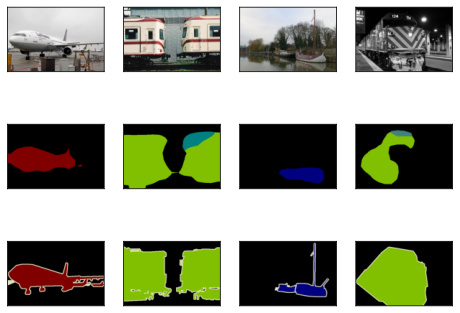

In [19]:
# Visualizing predicted classes
# Defining a function to convert predicted classes into an image
def label2image(pred):
    # Using VOC_COLORMAP to convert classes to RGB colors
    # VOC_COLORMAP is a list containing 21 different RGB colors, each corresponding to an object class
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])  # Converting class RGB values into a tensor
    # Converting the prediction results to long type to match the color map index
    X = pred.long()  # Converting the predicted values into indices
    # Finding the corresponding colors based on the class indices
    return colormap[X, :]  # Drawing the predicted RGB values

# Downloading and extracting the VOC2012 dataset
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
# Reading the test images and labels from the VOC2012 dataset
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
# Setting n to 4, indicating processing of 4 images. imgs: an empty list to store images.
n, imgs = 4, []
# Looping over predictions for 4 test samples and converting the prediction results to images
for i in range(n):
    # Setting the cropping area
    crop_rect = (0, 0, 320, 480)
    # Cropping the image
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    # Predicting on the cropped image and converting the prediction results into images
    pred = label2image(predict(X))  # Converting predictions into images
    # Adding the original image, predicted image, and label image to the imgs list
    imgs += [X.permute(1, 2, 0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1, 2, 0)]
# Displaying the original image, predicted image, and label image
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)  # Second row is predicted, third row is ground truth


In [24]:
test_labels

[tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
         

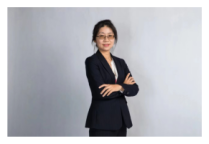

In [105]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn
image_path = '10.jpg'
image = Image.open(image_path)

# Define data preprocessing transformations for input images
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation transformations (e.g., random horizontal and vertical flipping)
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

input = image_transform(image).unsqueeze(0)
plt.imshow(image)
output = loaded_model(input)
prediction = output.argmax(dim=1).squeeze().cpu()
# plt.imshow(prediction)
plt.axis('off')
plt.show()

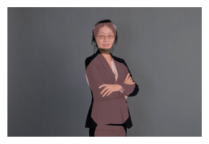

In [106]:
import numpy as np

# Define the colormap
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    indices = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((indices >> channel) & 1) << shift
        indices >>= 3

    return colormap

# Apply this colormap to label
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

# Get color mask from prediction
color_mask = label_to_color_image(prediction.numpy())
color_mask = Image.fromarray(color_mask.astype('uint8'))

# Opacity factor for the overlay
alpha = 0.5

# Convert the original image to a PIL image if needed
if not isinstance(image, Image.Image):
    image = F.to_pil_image(image)

# First, resize the prediction mask to the original image size
original_size = image.size  # Assuming `image` is a PIL image and has the original size
# Resize color_mask to match the original image size
color_mask = color_mask.resize(original_size, resample=Image.NEAREST)

# Ensure both images are in the same mode
if image.mode != 'RGB':
    image = image.convert('RGB')
if color_mask.mode != 'RGB':
    color_mask = color_mask.convert('RGB')

# Now blend them
combined_img = Image.blend(image, color_mask, alpha)
# Overlay the color mask on the original image
combined_img = Image.blend(image, color_mask, alpha)

# Display the combined image
plt.imshow(combined_img)
plt.axis('off')
plt.show()